# Intro to Intro to Machine Learning

## Imports

In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [92]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor
from IPython.display import display

from sklearn import metrics

In [ ]:
path = "data/bulldozers/"

## Introduction to *Blue Book for Bulldozers*

### About our teaching

At fast.ai we have a distinctive [teaching philosophy](http://www.fast.ai/2016/10/08/teaching-philosophy/) of ["the whole game"](https://www.amazon.com/Making-Learning-Whole-Principles-Transform/dp/0470633719/ref=sr_1_1?ie=UTF8&qid=1505094653).  This is different from how most traditional math & technical courses are taught, where you have to learn all the individual elements before you can combine them (Harvard professor David Perkins call this *elementitis*), but it is similar to how topics like *driving* and *baseball* are taught.  That is, you can start driving without [knowing how an internal combustion engine works](https://medium.com/towards-data-science/thoughts-after-taking-the-deeplearning-ai-courses-8568f132153), and children begin playing baseball before they learn all the formal rules.

### About this dataset

We will be looking at the Blue Book for Bulldozers Kaggle Competition: "The goal of the contest is to predict the sale price of a particular piece of heavy equiment at auction based on it's usage, equipment type, and configuaration.  The data is sourced from auction result postings and includes information on usage and equipment configurations."

This is a very common type of dataset and prediciton problem, and similar to what you may see in your project or workplace.

### About Kaggle Competitions

Kaggle is an awesome resource for aspiring data scientists or anyone looking to improve their machine learning skills.  There is nothing like being able to get hands-on practice and receiving real-time feedback to help you improve your skills.

Kaggle provides:

1. Interesting data sets
2. Feedback on how you're doing
3. A leader board to see what's good, what's possible, and what's state-of-art.
4. Blog posts by winning contestants share useful tips and techniques.

## The data

### Look at the data

Kaggle provides info about some of the fields of our dataset; on the [Kaggle Data info](https://www.kaggle.com/c/bluebook-for-bulldozers/data) page they say the following:

For this competition, you are predicting the sale price of bulldozers sold at auctions. The data for this competition is split into three parts:

- **Train.csv** is the training set, which contains data through the end of 2011.
- **Valid.csv** is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
- **Test.csv** is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

The key fields are in train.csv are:

- SalesID: the uniue identifier of the sale
- MachineID: the unique identifier of a machine.  A machine can be sold multiple times
- saleprice: what the machine sold for at auction (only provided in train.csv)
- saledate: the date of the sale

*Question*

What stands out to you from the above description?  What needs to be true of our training and validation sets?

In [314]:
df_raw = pd.read_csv(f'{path}Train.csv', low_memory=False, parse_dates=["saledate"])

In any sort of data science work, it's **important to look at your data**, to make sure you understand the format, how it's stored, what type of values it holds, etc. Even if you've read descriptions about your data, the actual data may not be what you expect.

In [239]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000): 
        with pd.option_context("display.max_columns", 1000): 
            display(df)

In [315]:
display_all(df_raw.tail().transpose())

,401120,401121,401122,401123,401124
SalesID,6333336,6333337,6333338,6333341,6333342
SalePrice,10500,11000,11500,9000,7750
MachineID,1840702,1830472,1887659,1903570,1926965
ModelID,21439,21439,21439,21435,21435
datasource,149,149,149,149,149
auctioneerID,1,1,1,2,2
YearMade,2005,2005,2005,2005,2005
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-10-25 00:00:00,2011-10-25 00:00:00


In [316]:
display_all(df_raw.describe(include='all').transpose())

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
SalesID,401125,NaN,NaN,NaN,NaN,NaN,1.91971e+06,909021,1.13925e+06,1.41837e+06,1.63942e+06,2.24271e+06,6.33334e+06
SalePrice,401125,NaN,NaN,NaN,NaN,NaN,31099.7,23036.9,4750,14500,24000,40000,142000
MachineID,401125,NaN,NaN,NaN,NaN,NaN,1.2179e+06,440992,0,1.0887e+06,1.27949e+06,1.46807e+06,2.48633e+06
ModelID,401125,NaN,NaN,NaN,NaN,NaN,6889.7,6221.78,28,3259,4604,8724,37198
datasource,401125,NaN,NaN,NaN,NaN,NaN,134.666,8.96224,121,132,132,136,172
auctioneerID,380989,NaN,NaN,NaN,NaN,NaN,6.55604,16.9768,0,1,2,4,99
YearMade,401125,NaN,NaN,NaN,NaN,NaN,1899.16,291.797,1000,1985,1995,2000,2013
MachineHoursCurrentMeter,142765,NaN,NaN,NaN,NaN,NaN,3457.96,27590.3,0,0,0,3025,2.4833e+06
UsageBand,69639,3,Medium,33985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
saledate,401125,3919,2009-02-16 00:00:00,1932,1989-01-17 00:00:00,2011-12-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Initial processing

In [317]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(df_raw.drop('SalePrice', axis=1), df_join.SalePrice)

ValueError: could not convert string to float: 'Conventional'

This dataset contains a mix of **continuous** and **categorical** variables.

The following method extracts particular date fields from a complete datetime for the purpose of constructing categoricals.  You should always consider this feature extraction step when working with date-time. Without expanding your date-time into these additional fields, you can't capture any trend/cyclical behavior as a function of time at any of these granularities.

In [318]:
add_datepart(df_raw, 'saledate')
df_raw.saleYear.head()

0    2006
1    2004
2    2004
3    2011
4    2009
Name: saleYear, dtype: int64

The categorical variables are currently stored as strings, which is inefficient, and doesn't provide the numeric coding required for a random forest. Therefore we call `train_cats` to convert strings to pandas categories.

In [319]:
train_cats(df_raw)

We can specify the order to use for categorical variables if we wish:

In [320]:
df_raw.UsageBand.cat.categories

Index(['High', 'Low', 'Medium'], dtype='object')

In [246]:
df_raw.UsageBand.cat.set_categories(['High', 'Medium', 'Low'], ordered=True, inplace=True)

We're still not quite done - for instance we have lots of missing values, wish we can't pass directly to a random forest.

In [322]:
display_all(df_raw.isnull().sum().sort_index()/len(df_raw))

Backhoe_Mounting            0.803872
Blade_Extension             0.937129
Blade_Type                  0.800977
Blade_Width                 0.937129
Coupler                     0.466620
Coupler_System              0.891660
Differential_Type           0.826959
Drive_System                0.739829
Enclosure                   0.000810
Enclosure_Type              0.937129
Engine_Horsepower           0.937129
Forks                       0.521154
Grouser_Tracks              0.891899
Grouser_Type                0.752813
Hydraulics                  0.200823
Hydraulics_Flow             0.891899
MachineHoursCurrentMeter    0.644089
MachineID                   0.000000
ModelID                     0.000000
Pad_Type                    0.802720
Pattern_Changer             0.752651
ProductGroup                0.000000
ProductGroupDesc            0.000000
ProductSize                 0.525460
Pushblock                   0.937129
Ride_Control                0.629527
Ripper                      0.740388
S

But let's save this file for now, since it's already in format can we be stored and accessed efficiently.

In [323]:
os.makedirs('tmp', exist_ok=True)
df_raw.to_feather('tmp/raw')

### Pre-processing

In the future we can simply read it from this fast format.

In [4]:
df_raw = pd.read_feather('tmp/raw')

We'll replace categories with their numeric codes, missing continuous values with a value higher than the column max, and split the dependent variable into a separate variable.

In [324]:
df_trn, y_trn = proc_df(df_raw, 'SalePrice')

Possibly **the most important idea** in machine learning is that of having separate training & validation data sets.

As motivation, suppose you don't divide up your data, but instead use all of it.  And suppose you have lots of parameters:

This is called over-fitting.  A validation set helps prevent this problem.

<img src="images/overfitting2.png" alt="" style="width: 70%"/>
<center>
[Underfitting and Overfitting](https://datascience.stackexchange.com/questions/361/when-is-a-model-underfitted)
</center>

The error for the pictured data points is lowest for the model on the far right (the blue curve passes through the red points almost perfectly), yet it's not the best choice.  Why is that?  If you were to gather some new data points, they most likely would not be on that curve in the graph on the right, but would be closer to the curve in the middle graph.

This illustrates how using all our data can lead to **overfitting**.

In [325]:
def split_vals(a,n): return a[:n], a[n:]

n_valid = 12000  # same as Kaggle's test set size
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn.values, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((389125, 56), (389125,), (12000, 56))

## Random Forests

### First model

We now have something we can pass to a random forest!

In [326]:
def print_score(m):
    res = [m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [327]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 57.5 s, sys: 108 ms, total: 57.6 s
Wall time: 6.02 s
[0.9824884723458398, 0.88256561908844189]


An r^2 in the high-80's isn't too bad, but we can see from the validation set score that we're over-fitting badly. To understand this issue, let's simplify things down to a single small tree.

*todo* define r^2

### Speeding things up

In [381]:
df_trn, y_trn = proc_df(df_raw, 'SalePrice', subset=30000)
X_train, _ = split_vals(df_trn.values, 20000)
y_train, _ = split_vals(y_trn, 20000)

In [382]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 3.23 s, sys: 20 ms, total: 3.25 s
Wall time: 436 ms
[0.9681094455880942, 0.83893820095683957]


### Single tree

In [383]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.45875618112014571, 0.50561358225908393]


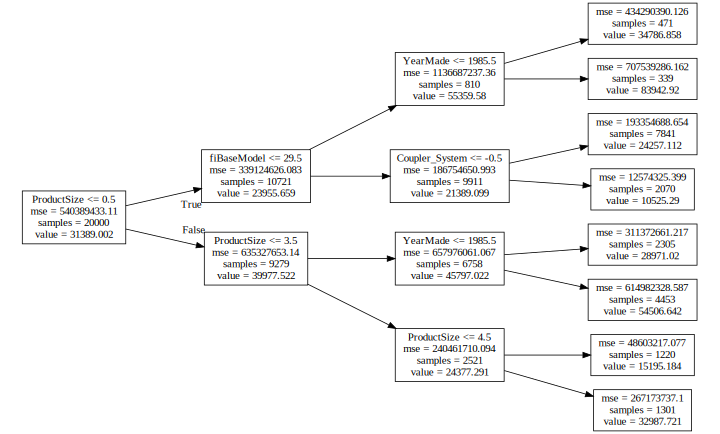

In [384]:
draw_tree(m.estimators_[0], df_trn)

Let's see what happens if we create a bigger tree.

In [385]:
m = RandomForestRegressor(n_estimators=1, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[1.0, 0.67407804318051467]


The training set result looks great! But the validation set is worse than our original model. This is why we need to use *bagging* of multiple trees to get more generalizable results.

### Bagging

To learn about bagging in random forests, let's start with our basic model again.

In [386]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.96811528539204417, 0.82445796698204454]


We'll grab the predictions for each individual tree, and look at one example.

In [387]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
preds[:,0], np.mean(preds[:,0]), y_valid[0]

(array([  9000.,  10000.,   8000.,   9250.,  26000.,  24500.,   8750.,  10000.,  18000.,  19500.]),
 14300.0,
 9000)

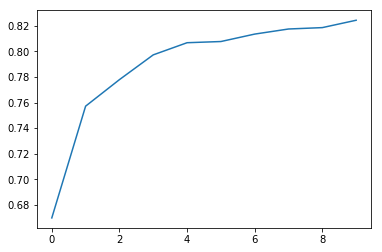

In [388]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)]);

The shape of this curve suggests that adding more trees isn't going to help us much. Let's check. (Compare this to our original model on a sample)

In [389]:
m = RandomForestRegressor(n_estimators=20, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.97318472825603197, 0.844618300512603]


In [390]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.97562017512220089, 0.84832752322624372]


### Subsampling

Let's return to using our full dataset, to try a better way to speed up our analysis.

In [453]:
df_trn, y_trn = proc_df(df_raw, 'SalePrice')
X_train, X_valid = split_vals(df_trn.values, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)

Rather than limit the total amount of data that our model can access, let's instead limit it to a *different* random subset per tree. That way, given enough trees, the model can still see *all* the data, but for each individual tree it'll be just as fast as if we had cut down our dataset as before.

In [394]:
set_rf_samples(20000)

In [396]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 5.13 s, sys: 48 ms, total: 5.18 s
Wall time: 693 ms
[0.87158773927235567, 0.83785781306834972]


Since each additional tree allows the model to see more data, this approach can make additional trees more useful.

In [399]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.88424836520313121, 0.86092732915801684]


### Out-of-bag (OOB) score

Is our validation set worse than our training set because we're over-fitting, or because the validation set is for a different time period, or a bit of both? With the existing information we've shown, we can't tell. However, random forests have a very clever trick called *out-of-bag (OOB) error* which can handle this (and more!)

The idea is to calculate error on the training set, but only include the trees in the calculation of a row's error where that row was *not* included in training that tree. This allows us to see whether the model is over-fitting, without needing a separate validation set.

This also has the benefit of allowing us to see whether our model generalizes, even if we only have a small amount of data so want to avoid separating some out to create a validation set.

This is as simple as adding one more parameter to our model constructor. We print the OOB error last in our `print_score` function below.

In [400]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.88427181627781215, 0.86241779186902146, 0.87188632966228308]


This shows that our validation set time difference is making an impact, as is model over-fitting.

### Reducing over-fitting

We revert to using a full bootstrap sample in order to show the impact of other over-fitting avoidance methods.

In [454]:
reset_rf_samples()

Let's get a baseline for this full set to compare to.

In [402]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.98688761678618198, 0.89460255787820453, 0.90651391544869742]


Another way to reduce over-fitting is to grow our trees less deeply. We do this by specifying (with `min_samples_leaf`) that we require some minimum number of rows in every leaf node. This has two benefits:

- There are less decision rules for each leaf node; simpler models should generalize better
- The predictions are made by averaging more rows in the leaf node, resulting in less volatility

In [408]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.97068822989645953, 0.89270066643877044, 0.9067022155289185]


We can also increase the amount of variation amongst the trees by not only use a sample of rows for each tree, but to also using a sample of *columns* for each *split*. We do this by specifying `max_features`, which is the proportion of features to randomly select from at each split.

In [415]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.96830743688175047, 0.90099995037939107, 0.90976343913326707]


The sklearn docs [show an example](http://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html) of different `max_features` methods with increasing numbers of trees - as you see, using a subset of features on each split requires using more trees, but results in better models:
![sklearn max_features chart](http://scikit-learn.org/stable/_images/sphx_glr_plot_ensemble_oob_001.png)

### Feature importance

In [462]:
df_trn, y_trn = proc_df(df_raw, 'SalePrice')
X_train, X_valid = split_vals(df_trn.values, n_trn)

It's not normally enough to just to know that a model can make accurate predictions - we also want to know *how* it's making predictions. The most important way to see this is with *feature importances*.

In [463]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.96836793642727814, 0.90062250058322413, 0.90957312759338005]


In [464]:
fi = rf_feat_importance(m, df_trn); fi[:10]

,cols,imp
5,YearMade,0.201512
13,ProductSize,0.164398
19,Enclosure,0.074925
10,fiSecondaryDesc,0.071892
55,saleElapsed,0.064756
8,fiModelDesc,0.051997
2,ModelID,0.046308
14,fiProductClassDesc,0.045573
9,fiBaseModel,0.043564
0,SalesID,0.035465


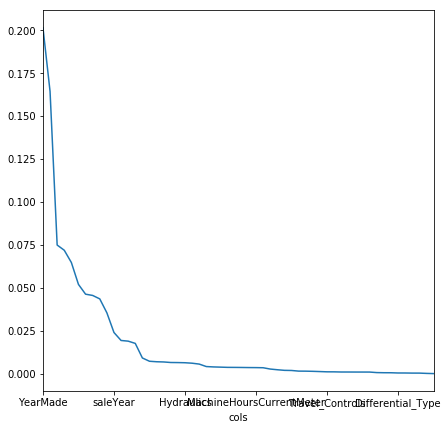

In [465]:
fi.plot('cols', 'imp', figsize=(7,7), legend=False);

In [466]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

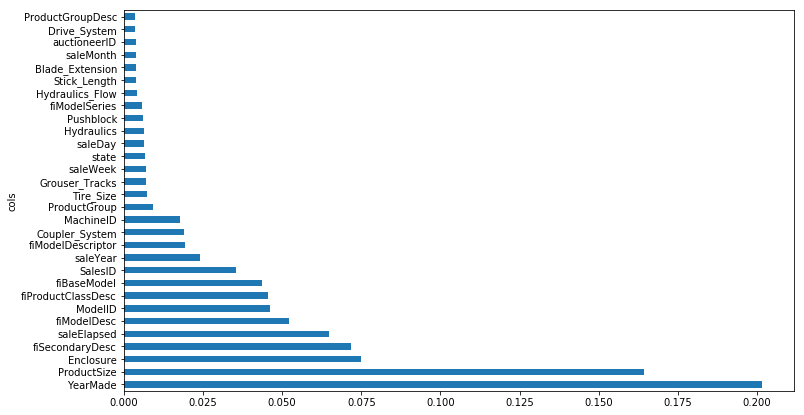

In [469]:
plot_fi(fi[:30]);

In [422]:
to_keep = fi[fi.imp>0.004].cols; len(to_keep)

26

In [616]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = df_keep.values[:n_trn], df_keep.values[n_trn:]

In [617]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.96655522025717233, 0.90426496968982206, 0.90845379442921892]


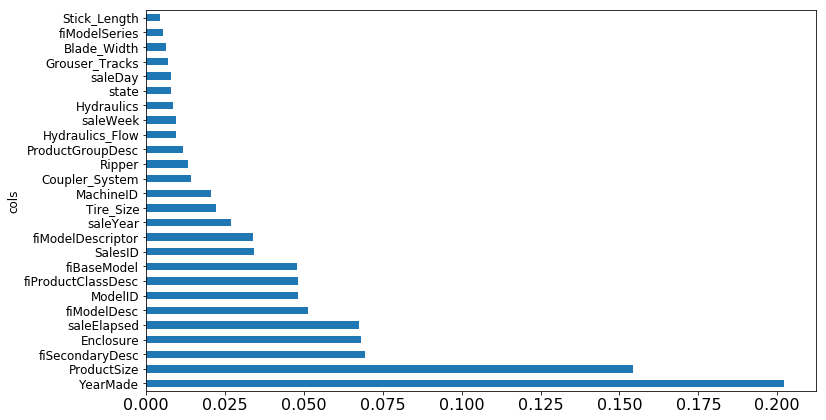

In [618]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

In [619]:
ignore=['saleDay', 'saleYear']
df = df_keep.drop(ignore, axis=1).copy()
X_train, X_valid = split_vals(df.values, n_trn)

In [620]:
m = RandomForestRegressor(n_estimators=64, min_samples_leaf=4, max_features=0.6,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.95834205306380027, 0.90176442723396943, 0.90902805906848116]


TODO: write about How to decide which are categorical and which are continuous

In [447]:
df_trn2, y_trn = proc_df(df_raw, 'SalePrice', max_n_cat=6)
X_train, X_valid = split_vals(df_trn2.values, n_trn)

In [436]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.96911788163208734, 0.89604190432642794, 0.9083105993812608]


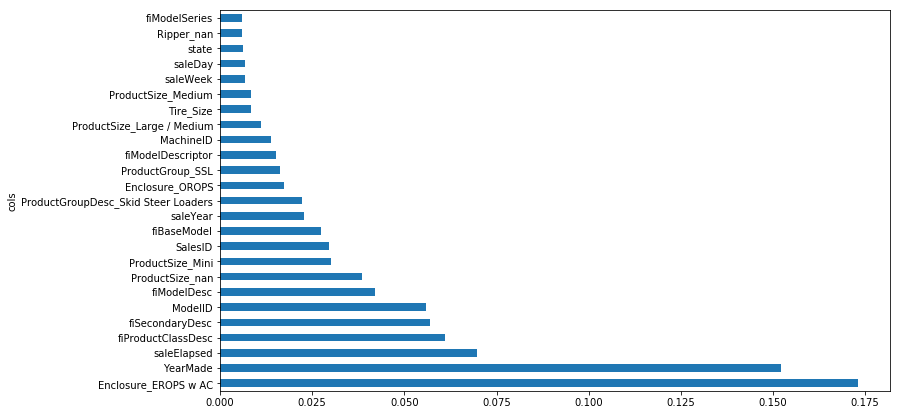

In [437]:
fi = rf_feat_importance(m, df_trn2)
plot_fi(fi[:25]);

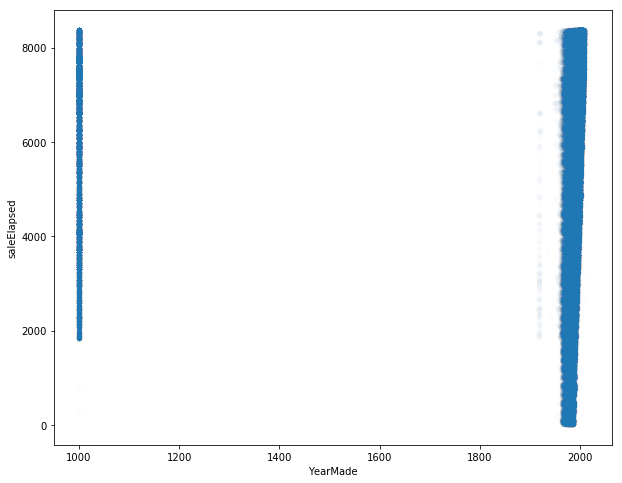

In [438]:
df.plot('YearMade', 'saleElapsed', 'scatter', alpha=0.01, figsize=(10,8));

In [439]:
df.loc[df.YearMade<1900, 'YearMade'] = 2020

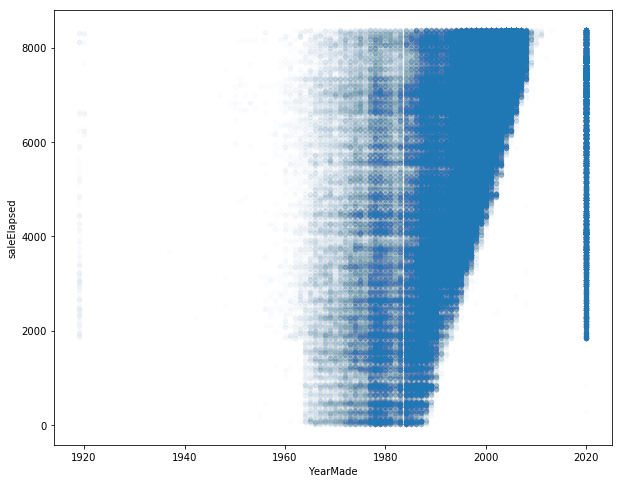

In [440]:
df.plot('YearMade', 'saleElapsed', 'scatter', alpha=0.01, figsize=(10,8));

In [448]:
df_trn2['age'] = df_trn2.saleYear-df_trn2.YearMade
X_train, X_valid = df_trn2.values[:n_trn], df_trn2.values[n_trn:]

In [449]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.96939966051965665, 0.89412171464319046, 0.90855458606099249]


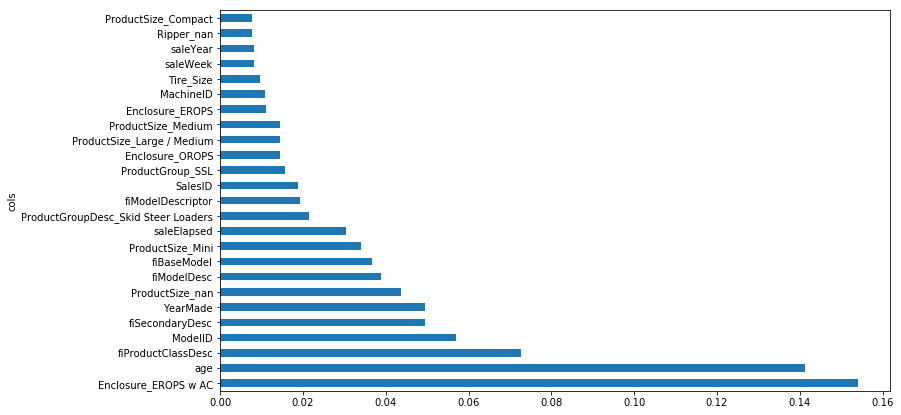

In [451]:
fi = rf_feat_importance(m, df_trn2)
plot_fi(fi[:25]);

### Removing redundent features

One thing that makes this harder to interpret is that there seem to be some variables with very similar meanings. Let's try to remove redundent features.

In [571]:
from scipy.cluster import hierarchy as hc

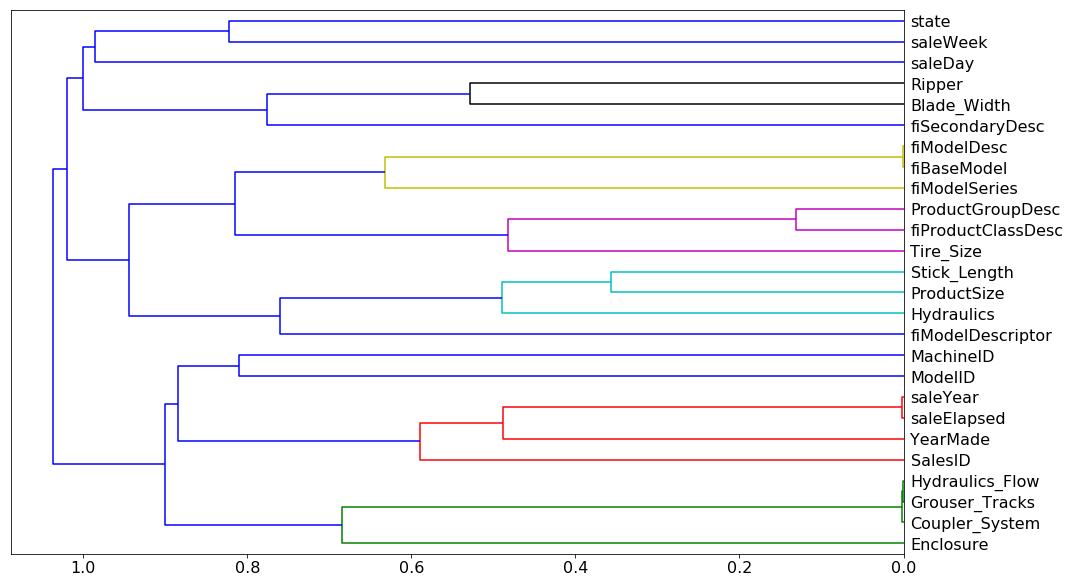

In [621]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

Let's try removing some of these related features to see if the model can be simplified without impacting the accuracy. When we're comparing a few different models we can use sampling to speed up model creation, since the comparisons will be equally valid (even if the models are a little less accurate).

In [577]:
set_rf_samples(50000)

In [599]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df.values, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

Here's our baseline.

In [591]:
get_oob(df_keep)

0.88509439336739149

Now we try removing each variable one at a time.

In [592]:
for c in ('fiModelDesc', 'fiBaseModel', 'saleYear', 'saleElapsed', 'Hydraulics_Flow', 'Grouser_Tracks', 'Coupler_System'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

fiModelDesc 0.88376979471
fiBaseModel 0.884291261629
saleYear 0.884524108166
saleElapsed 0.881384001791
Hydraulics_Flow 0.88472963665
Grouser_Tracks 0.885620162507
Coupler_System 0.884344902911


It looks like we can try one from each group for removal. Let's see what that does.

In [593]:
to_drop = ['fiBaseModel', 'saleYear', 'Grouser_Tracks']
for c in ('fiModelDesc', 'saleElapsed', 'Hydraulics_Flow', 'Coupler_System'):
    print(c, get_oob(df_keep.drop(to_drop+[c], axis=1)))

fiModelDesc 0.880028268265
saleElapsed 0.873863381029
Hydraulics_Flow 0.883631573567
Coupler_System 0.882488358333


...and try removing one more from the largest cluster:

In [600]:
to_drop = ['fiBaseModel', 'saleYear', 'Grouser_Tracks', 'Hydraulics_Flow']
for c in ('fiModelDesc', 'saleElapsed', 'Coupler_System'):
    print(c, get_oob(df_keep.drop(to_drop+[c], axis=1)))

fiModelDesc 0.879541268985
saleElapsed 0.874172735687
Coupler_System 0.883211349435


Looking good! Let's use this dataframe from here.

In [602]:
df_keep.drop(to_drop, axis=1, inplace=True)

And let's see how this model looks on the full dataset:

In [611]:
reset_rf_samples()

In [614]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
X_train, X_valid = split_vals(df_keep.values, n_trn)
m.fit(X_train, y_train)
print_score(m)

[0.96601427876860835, 0.90236935851748168, 0.90741679933750785]


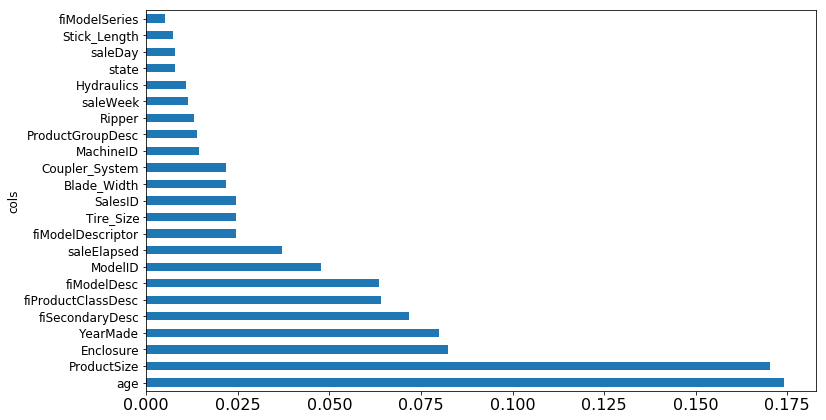

In [615]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

### Partial dependence

*todo* add interactions (see R code)

*todo* extrapolate future dates better. use RF to decide if something is in train or validation. note: it's a classification problem!

*todo* confidence based on tree variance

### Functions, parameters, and training

A **function** takes inputs and returns outputs. For instance, $f(x) = 3x + 5$ is an example of a function.  If we input $2$, the output is $3\times 2 + 5 = 11$, or if we input $-1$, the output is $3\times (-1) + 5 = 2$

Functions have **parameters**. The above function $f$ is $ax + b$, with parameters a and b set to $a=3$ and $b=5$.

Machine learning is often about learning the best values for those parameters.  For instance, suppose we have the data points on the chart below.  What values should we choose for $a$ and $b$?

<img src="images/sgd2.gif" alt="" style="width: 70%"/>

In the above gif fast.ai Practical Deep Learning for Coders course, [intro to SGD notebook](https://github.com/fastai/courses/blob/master/deeplearning1/nbs/sgd-intro.ipynb)), an algorithm called stochastic gradient descent is being used to learn the best parameters to fit the line to the data (note: in the gif, the algorithm is stopping before the absolute best parameters are found).  This process is called **training** or **fitting**.

Most datasets will not be well-represented by a line.  We could use a more complicated function, such as $g(x) = ax^2 + bx + c + \sin d$.  Now we have 4 parameters to learn: $a$, $b$, $c$, and $d$.  This function is more flexible than $f(x) = ax + b$ and will be able to accurately model more datasets.

Neural networks take this to an extreme, and are infinitely flexible.  They often have thousands, or even hundreds of thousands of parameters.  However the core idea is the same as above.  The neural network is a function, and we will learn the best parameters for modeling our data.

### Imports

In [8]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.io import *

## Data

Today we will be working with MNIST, a classic data set of hand-written digits.  Solutions to this problem are used by banks to automatically recognize the amounts on checks, and by the postal service to automatically recognize zip codes on mail.

<img src="images/mnist.png" alt="" style="width: 60%"/>

A matrix can represent an image, by creating a grid where each entry corresponds to a different pixel.

<img src="images/digit.gif" alt="digit" style="width: 55%"/>
  (Source: [Adam Geitgey
](https://medium.com/@ageitgey/machine-learning-is-fun-part-3-deep-learning-and-convolutional-neural-networks-f40359318721))


### Download

Let's download, unzip, and format the data.

In [14]:
path = '../data/'

In [15]:
import os
os.makedirs(path, exist_ok=True)

In [16]:
URL='http://deeplearning.net/data/mnist/'
FILENAME='mnist.pkl.gz'

def load_mnist(filename):
    return pickle.load(gzip.open(filename, 'rb'), encoding='latin-1')

In [116]:
get_data(URL+FILENAME, path+FILENAME)
((x, y), (x_valid, y_valid), _) = load_mnist(path+FILENAME)

### Normalize

Many machine learning algorithms behave better when the data is *normalized*, that is when the mean is 0 and the standard deviation is 1. We will subtract off the mean and standard deviation from our training set in order to normalize the data:

In [18]:
mean = x.mean()
std = x.std()

In [19]:
x=(x-mean)/std
x.mean(), x.std()

(-3.1638146e-07, 0.99999934)

Note that for consistency (with the parameters we learn when training), we subtract the mean and standard deviation of our training set from our validation set. 

In [20]:
x_valid = (x_valid-mean)/std
x_valid.mean(), x_valid.std()

(-0.0058509219, 0.99243325)

### Look at the data

In any sort of data science work, it's important to look at your data, to make sure you understand the format, how it's stored, what type of values it holds, etc. To make it easier to work with, let's reshape it into 2d images from the flattened 1d format.

#### Helper methods

In [23]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def show(img, title=None):
    plt.imshow(img, interpolation='none', cmap="gray")
    if title is not None: plt.title(title)

In [24]:
def plots(ims, figsize=(12,6), rows=2, titles=None):
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation='none', cmap='gray')

#### Plots 

In [97]:
x_valid.shape

(10000, 784)

In [25]:
x_imgs = np.reshape(x_valid, (-1,28,28)); x_imgs.shape

(10000, 28, 28)

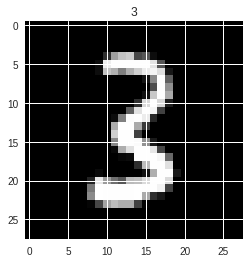

In [99]:
show(x_imgs[0], y_valid[0])

In [117]:
y_valid.shape

(10000,)

It's the digit 3!  And that's stored in the y value:

In [100]:
y_valid[0]

3

We can look at part of an image:

In [26]:
x_imgs[0,10:15,10:15]

array([[-0.4245, -0.4245, -0.4245, -0.4245,  0.1729],
       [-0.4245, -0.4245, -0.4245,  0.7831,  2.4357],
       [-0.4245, -0.272 ,  1.2026,  2.7789,  2.8043],
       [-0.4245,  1.7619,  2.8043,  2.8043,  1.7365],
       [-0.4245,  2.2069,  2.8043,  2.8043,  0.4018]], dtype=float32)

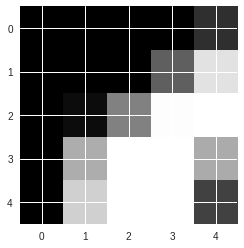

In [29]:
show(x_imgs[0,10:15,10:15])

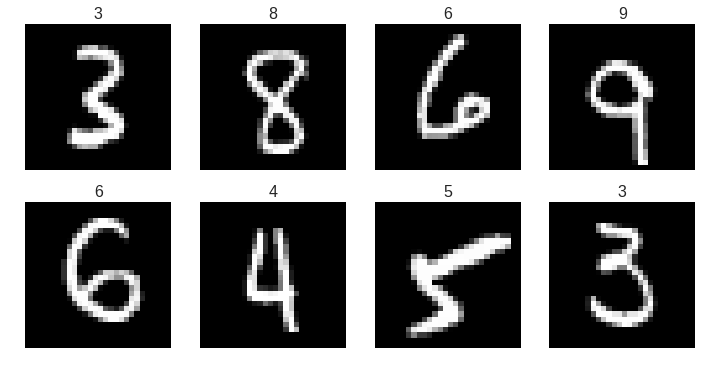

In [101]:
plots(x_imgs[:8], titles=y_valid[:8])

## The Most Important Machine Learning Concepts

### Functions, parameters, and training

A **function** takes inputs and returns outputs. For instance, $f(x) = 3x + 5$ is an example of a function.  If we input $2$, the output is $3\times 2 + 5 = 11$, or if we input $-1$, the output is $3\times (-1) + 5 = 2$

Functions have **parameters**. The above function $f$ is $ax + b$, with parameters a and b set to $a=3$ and $b=5$.

Machine learning is often about learning the best values for those parameters.  For instance, suppose we have the data points on the chart below.  What values should we choose for $a$ and $b$?

<img src="images/sgd2.gif" alt="" style="width: 70%"/>

In the above gif fast.ai Practical Deep Learning for Coders course, [intro to SGD notebook](https://github.com/fastai/courses/blob/master/deeplearning1/nbs/sgd-intro.ipynb)), an algorithm called stochastic gradient descent is being used to learn the best parameters to fit the line to the data (note: in the gif, the algorithm is stopping before the absolute best parameters are found).  This process is called **training** or **fitting**.

Most datasets will not be well-represented by a line.  We could use a more complicated function, such as $g(x) = ax^2 + bx + c + \sin d$.  Now we have 4 parameters to learn: $a$, $b$, $c$, and $d$.  This function is more flexible than $f(x) = ax + b$ and will be able to accurately model more datasets.

Neural networks take this to an extreme, and are infinitely flexible.  They often have thousands, or even hundreds of thousands of parameters.  However the core idea is the same as above.  The neural network is a function, and we will learn the best parameters for modeling our data.

### Training & Validation data sets

Possibly **the most important idea** in machine learning is that of having separate training & validation data sets.

As motivation, suppose you don't divide up your data, but instead use all of it.  And suppose you have lots of parameters:

This is called over-fitting.  A validation set helps prevent this problem.

<img src="images/overfitting2.png" alt="" style="width: 70%"/>
<center>
[Underfitting and Overfitting](https://datascience.stackexchange.com/questions/361/when-is-a-model-underfitted)
</center>

The error for the pictured data points is lowest for the model on the far right (the blue curve passes through the red points almost perfectly), yet it's not the best choice.  Why is that?  If you were to gather some new data points, they most likely would not be on that curve in the graph on the right, but would be closer to the curve in the middle graph.

This illustrates how using all our data can lead to **overfitting**.

## Neural Net (with nn.torch)

### Imports 

In [31]:
from fastai.metrics import *
from fastai.model import *
from fastai.dataset import *
from fastai.core import *

import torch.nn as nn

###  Neural networks 

We will use fastai's ImageClassifierData, which holds our training and validation sets and will provide batches of that data in a form ready for use by a PyTorch model.

In [32]:
md = ImageClassifierData.from_arrays(path, (x,y), (x_valid, y_valid))

We will begin with the highest level abstraction: using a neural net defined by PyTorch's Sequential class.  

In [33]:
net = nn.Sequential(
    nn.Linear(28*28, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
).cuda()

Each input is a vector of size $28\times 28$ pixels and our output is of size $10$ (since there are 10 digits: 0, 1, ..., 9). 

We use the output of the final layer to generate our predictions.  Often for classification problems (like MNIST digit classification), the final layer has the same number of outputs as there are classes.  In that case, this is 10: one for each digit from 0 to 9.  These can be converted to comparative probabilities.  For instance, it may be determined that a particular hand-written image is 80% likely to be a 4, 18% likely to be a 9, and 2% likely to be a 3.  In our case, we are not interested in viewing the probabilites, and just want to see what the most likely guess is.

### Layers

Sequential defines layers of our network, so let's talk about layers. Neural networks consist of **linear layers alternating with non-linear layers**.  This creates functions which are incredibly flexible.  Deeper layers are able to capture more complex patterns.

Layer 1 of a convolutional neural network:
<img src="images/zeiler1.png" alt="pytorch" style="width: 40%"/>
<center>
[Matthew Zeiler and Rob Fergus](http://www.matthewzeiler.com/wp-content/uploads/2017/07/arxive2013.pdf)
</center>

Layer 2:
<img src="images/zeiler2.png" alt="pytorch" style="width: 90%"/>
<center>
[Matthew Zeiler and Rob Fergus](http://www.matthewzeiler.com/wp-content/uploads/2017/07/arxive2013.pdf)
</center>

Deeper layers can learn about more complicated shapes (although we are only using 2 layers in our network):
<img src="images/zeiler4.png" alt="pytorch" style="width: 90%"/>
<center>
[Matthew Zeiler and Rob Fergus](http://www.matthewzeiler.com/wp-content/uploads/2017/07/arxive2013.pdf)
</center>

### Training the network 

In [123]:
net

Sequential (
  (0): Linear (784 -> 256)
  (1): ReLU ()
  (2): Linear (256 -> 10)
)

In [124]:
784*256 + 256*10

203264

Next we will set a few inputs for our *fit* method:
- **Optimizer**: algorithm for finding the minimum. typically these are variations on *stochastic gradient descent*, involve taking a step that appears to be the right direction based on the change in the function.
- **Loss**: what function is the optimizer trying to minimize?  We need to say how we're defining the error.
- **Metrics**: other calculations you want printed out as you train

In [34]:
loss=F.cross_entropy
metrics=[accuracy]
opt=optim.Adam(net.parameters())

*Fitting* is the process by which the neural net learns the best parameters for the dataset.

In [35]:
fit(net, md, epochs=1, crit=loss, opt=opt, metrics=metrics)

[ 0.1397  0.1193  0.9668]



GPUs are great at handling lots of data at once (otherwise don't get performance benefit).  We break the data up into **batches**, and that specifies how many samples from our dataset we want to send to the GPU at a time.  The fastai library defaults to a batch size of 64.  On each iteration of the training loop, the error on 1 batch of data will be calculated, and the optimizer will update the parameters based on that.

An **epoch** is completed once each data sample has been used once in the training loop.

Now that we have the parameters for our model, we can make predictions on our validation set.

In [36]:
preds = predict(net, md.val_dl)

In [37]:
preds = preds.max(1)[1]

Let's see how some of our preditions look!

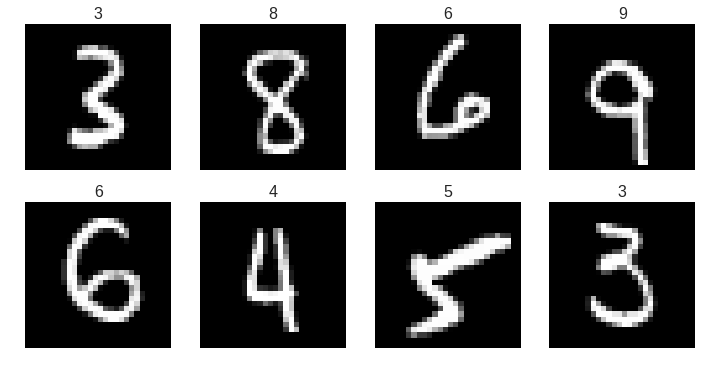

In [38]:
plots(x_imgs[:8], titles=preds[:8])

These predictions are pretty good!

## Coding the Neural Net ourselves

Recall that above we used PyTorch's `Sequential` to define a neural network with a linear layer, a non-linear layer (`ReLU`), and then another linear layer.

In [115]:
# Our code from above
net = nn.Sequential(
    nn.Linear(28*28, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
).cuda()

It turns out that `Linear` is defined by a matrix multiplication and then an addition.  Let's try defining this ourselves. This will allow us to see exactly where matrix multiplication is used (we will dive in to how matrix multiplication works in teh next section).  

Just as Numpy has `np.matmul` for matrix multiplication (in Python 3, this is equivalent to the `@` operator), PyTorch has `torch.matmul`.  

PyTorch class has two things: constructor (says parameters) and a forward method (how to calculate prediction using those parameters)  The method `forward` describes how the neural net converts inputs to outputs.

In PyTorch, the optimizer knows to try to optimize any attribute of type **Parameter**.

In [114]:
def get_weights(*dims): return nn.Parameter(torch.randn(*dims)/dims[0])

In [104]:
class SimpleMnist(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1_w = get_weights(28*28, 256)  # Layer 1 weights
        self.l1_b = get_weights(256)         # Layer 1 bias
        self.l2_w = get_weights(256, 10)     # Layer 2 weights
        self.l2_b = get_weights(10)          # Layer 2 bias

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.matmul(x, self.l1_w) + self.l1_b  # Linear Layer
        x = x * (x > 0).float()                     # Non-linear Layer
        x = torch.matmul(x, self.l2_w) + self.l2_b  # Linear Layer
        return x

We create our neural net and the optimizer.  (We will use the same loss and metrics from above).

In [102]:
net2 = SimpleMnist().cuda()
opt=optim.Adam(net2.parameters())

In [103]:
fit(net2, md, epochs=1, crit=loss, opt=opt, metrics=metrics)

[ 0.      0.1635  0.1474  0.9559]



Now we can check our predictions:

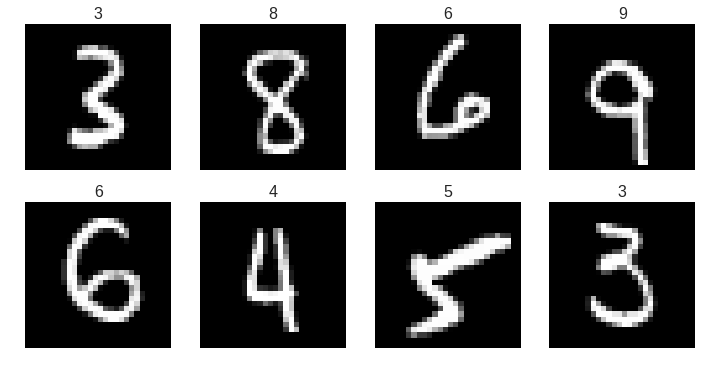

In [90]:
preds = predict(net2, md.val_dl).max(1)[1]
plots(x_imgs[:8], titles=preds[:8])

## what torch.matmul (matrix multiplication) is doing

Now let's dig in to what we were doing with `torch.matmul`: matrix multiplication.  First, let's start with a simpler building block: **broadcasting**.

### Element-wise operations 

Broadcasting and element-wise operations are supported in the same way by both numpy and pytorch.

Operators (+,-,\*,/,>,<,==) are usually element-wise.

Examples of element-wise operations:

In [44]:
a = np.array([10, 6, -4])
b = np.array([2, 8, 7])

In [45]:
a + b

array([12, 14,  3])

In [46]:
a < b

array([False,  True,  True], dtype=bool)

### Broadcasting

The term **broadcasting** describes how arrays with different shapes are treated during arithmetic operations.  The term broadcasting was first used by Numpy, although is now used in other libraries such as [Tensorflow](https://www.tensorflow.org/performance/xla/broadcasting) and Matlab; the rules can vary by library.

From the [Numpy Documentation](https://docs.scipy.org/doc/numpy-1.10.0/user/basics.broadcasting.html):

    The term broadcasting describes how numpy treats arrays with 
    different shapes during arithmetic operations. Subject to certain 
    constraints, the smaller array is “broadcast” across the larger 
    array so that they have compatible shapes. Broadcasting provides a 
    means of vectorizing array operations so that looping occurs in C
    instead of Python. It does this without making needless copies of 
    data and usually leads to efficient algorithm implementations.
    
In addition to the efficiency of broadcasting, it allows developers to write less code, which typically leads to fewer errors.

*This section was adapted from [Chapter 4](http://nbviewer.jupyter.org/github/fastai/numerical-linear-algebra/blob/master/nbs/4.%20Compressed%20Sensing%20of%20CT%20Scans%20with%20Robust%20Regression.ipynb#4.-Compressed-Sensing-of-CT-Scans-with-Robust-Regression) of the fast.ai [Computational Linear Algebra](https://github.com/fastai/numerical-linear-algebra) course.*

#### Broadcasting with a scalar

In [105]:
a

array([10,  6, -4])

In [66]:
a > 0

array([ True,  True, False], dtype=bool)

How are we able to do a > 0?  0 is being **broadcast** to have the same dimensions as a.

Remember above when we normalized our dataset by subtracting the mean (a scalar) from the entire data set (a matrix) and dividing by the standard deviation (another scalar)?  

    x=(x-mean)/std

We were using broadcasting!

Other examples of broadcasting with a scalar:

In [67]:
a + 1

array([11,  7, -3])

In [68]:
m = np.array([[1, 2, 3], [4,5,6], [7,8,9]]); m

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [69]:
m * 2

array([[ 2,  4,  6],
       [ 8, 10, 12],
       [14, 16, 18]])

#### Broadcasting a vector to a matrix

We can also broadcast a vector to a matrix:

In [70]:
c = np.array([10,20,30]); c

array([10, 20, 30])

In [71]:
m + c

array([[11, 22, 33],
       [14, 25, 36],
       [17, 28, 39]])

Although numpy does this automatically, you can also use the `broadcast_to` method:

In [72]:
np.broadcast_to(c, (3,3))

array([[10, 20, 30],
       [10, 20, 30],
       [10, 20, 30]])

In [91]:
c.shape

(3,)

The numpy `expand_dims` method lets us convert the 1-dimensional array `c` into a 2-dimensional array (although one of those dimensions has value 1).

In [74]:
np.expand_dims(c,0).shape

(1, 3)

In [75]:
m + np.expand_dims(c,0)

array([[11, 22, 33],
       [14, 25, 36],
       [17, 28, 39]])

In [76]:
np.expand_dims(c,1).shape

(3, 1)

In [77]:
m + np.expand_dims(c,1)

array([[11, 12, 13],
       [24, 25, 26],
       [37, 38, 39]])

In [78]:
np.broadcast_to(np.expand_dims(c,1), (3,3))

array([[10, 10, 10],
       [20, 20, 20],
       [30, 30, 30]])

#### Broadcasting Rules

When operating on two arrays, Numpy/PyTorch compares their shapes element-wise. It starts with the **trailing dimensions**, and works its way forward. Two dimensions are **compatible** when

- they are equal, or
- one of them is 1

Arrays do not need to have the same number of dimensions. For example, if you have a $256 \times 256 \times 3$ array of RGB values, and you want to scale each color in the image by a different value, you can multiply the image by a one-dimensional array with 3 values. Lining up the sizes of the trailing axes of these arrays according to the broadcast rules, shows that they are compatible:

    Image  (3d array): 256 x 256 x 3
    Scale  (1d array):             3
    Result (3d array): 256 x 256 x 3

The [numpy documentation](https://docs.scipy.org/doc/numpy-1.13.0/user/basics.broadcasting.html#general-broadcasting-rules) includes several examples of what dimensions can and can not be broadcast together.

### Matrix Multiplication

We are going to use broadcasting to define matrix multiplication.

#### Matrix-Vector Multiplication

In [79]:
m, c

(array([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]]), array([10, 20, 30]))

In [93]:
m @ c  # np.matmul(m, c)

array([140, 320, 500])

We get the same answer using `torch.matmul`:

In [92]:
torch.matmul(torch.from_numpy(m), torch.from_numpy(c))


 140
 320
 500
[torch.LongTensor of size 3]

The following is **NOT** matrix multiplication.  What is it?

In [67]:
m * c

array([[ 10,  40,  90],
       [ 40, 100, 180],
       [ 70, 160, 270]])

In [70]:
(m * c).sum(axis=1)

array([140, 320, 500])

In [115]:
c

array([10, 20, 30])

In [114]:
np.broadcast_to(c, (3,3))

array([[10, 20, 30],
       [10, 20, 30],
       [10, 20, 30]])

From a machine learning perspective, matrix multiplication is a way of creating features by saying how much we want to weight each input column.  **Different features are different weighted averages of the input columns**. 

The website [matrixmultiplication.xyz](http://matrixmultiplication.xyz/) provides a nice visualization of matrix multiplcation

Draw a picture

In [113]:
n = np.array([[10,40],[20,0],[30,-5]]); n

array([[10, 40],
       [20,  0],
       [30, -5]])

In [111]:
m @ n

array([[140, 100],
       [320, 280],
       [500, 460]])

In [118]:
(m * n[:,0]).sum(axis=1)

array([140, 320, 500])

In [119]:
(m * n[:,1]).sum(axis=1)

array([ 25, 130, 235])

## Homework: another use of broadcasting

If you want to test your understanding of the above tutorial.  I encourage you to work through it again, only this time use **CIFAR 10**, a dataset that consists of 32x32 *color* images in 10 different categories.  Color images have an extra dimension, containing RGB values, compared to black & white images.

<img src="images/cifar10.png" alt="" style="width: 70%"/>
<center>
(source: [Cifar 10](https://www.cs.toronto.edu/~kriz/cifar.html))
</center>

Fortunately, broadcasting will make it relatively easy to add this extra dimension (for color RGB), but you will have to make some changes to the code.

## Other applications of Matrix and Tensor Products

Here are some other examples of where matrix multiplication arises.  This material is taken from [Chapter 1](http://nbviewer.jupyter.org/github/fastai/numerical-linear-algebra/blob/master/nbs/1.%20Why%20are%20we%20here.ipynb) of my [Computational Linear Algebra](https://github.com/fastai/numerical-linear-algebra) course. 

#### Matrix-Vector Products:

The matrix below gives the probabilities of moving from 1 health state to another in 1 year.  If the current health states for a group are:
- 85% asymptomatic
- 10% symptomatic
- 5% AIDS
- 0% death

what will be the % in each health state in 1 year?

<img src="images/markov_health.jpg" alt="floating point" style="width: 80%"/>(Source: [Concepts of Markov Chains](https://www.youtube.com/watch?v=0Il-y_WLTo4))

#### Answer

In [6]:
import numpy as np

In [19]:
#Exercise: Use Numpy to compute the answer to the above


array([[ 0.765 ],
       [ 0.1525],
       [ 0.0645],
       [ 0.018 ]])

#### Matrix-Matrix Products

<img src="images/shop.png" alt="floating point" style="width: 100%"/>(Source: [Several Simple Real-world Applications of Linear Algebra Tools](https://www.mff.cuni.cz/veda/konference/wds/proc/pdf06/WDS06_106_m8_Ulrychova.pdf))

#### Answer

In [23]:
#Exercise: Use Numpy to compute the answer to the above


array([[ 50. ,  49. ],
       [ 58.5,  61. ],
       [ 43.5,  43.5]])

## End

A Tensor is a *multi-dimensional matrix containing elements of a single data type*: a group of data, all with the same type (e.g. A Tensor could store a 4 x 4 x 6 matrix of 32-bit signed integers).